# On Numerical Methods of Differential Equations

## 1. Contents

**Explicit Runge-Kutta methods and automatic step size control.** We construct our own ODE solver, based on an explicit Runge-Kutta method with embedded error estimator. The error estimator is used to adjust the time step $h$ along the integration, so that the error estimate is kept close to a prescribed accuracy tolerance tol.

**Stiff vs. nonstiff problems.** We focus on understanding the distinction between stiff and nonstiff problems, and why stiff problems require implicit methods with unbounded stability regions. We will study two nonlinear oscillatory systems, the nonstiff Lotka-Volterra population dynamics problem and the van der Pol equation, which may be stiff or nonstiff depending on problem parameters. We work both with our own solver, and a professionally implemented stiff ODE solver.

In [8]:
# Importing relevant libraries
import numpy as np
import math as math
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.figsize'] = [5, 5]
import collections.abc

## 2. Explicit adaptive Runge-Kutta methods

**Theory.** An explicit Runge-Kutta method for the initial value problem $y^{\prime}=f(t, y)$ is a method of the form exemplified by the classical 4th-order Runge-Kutta method (also known as RK4)

$$
\begin{aligned}
Y_{1}^{\prime} &=f\left(t_{n}, y_{n}\right) \\
Y_{2}^{\prime} &=f\left(t_{n}+h / 2, y_{n}+h Y_{1}^{\prime} / 2\right) \\
Y_{3}^{\prime} &=f\left(t_{n}+h / 2, y_{n}+h Y_{2}^{\prime} / 2\right) \\
Y_{4}^{\prime} &=f\left(t_{n}+h, y_{n}+h Y_{3}^{\prime}\right) \\
y_{n+1} &=y_{n}+\frac{h}{6}\left(Y_{1}^{\prime}+2 Y_{2}^{\prime}+2 Y_{3}^{\prime}+Y_{4}^{\prime}\right)
\end{aligned}
$$

A single step of the method can then be described as follows. The method "samples" the right-hand side $f(t, y)$ at four different points to compute the four **stage derivatives** $Y_{1}^{\prime}, Y_{2}^{\prime}, Y_{3}^{\prime}$ and $Y_{4}^{\prime}$. Then it forms a linear combination of these derivatives to obtain the "average derivative" to advance the solution from $y_{n}$ to $y_{n+1}$.

A general Runge-Kutta method is defined by its coefficients $a_{i j}$ for evaluating the $Y_{i}^{\prime}$, and the coefficients $b_{j}$ for forming the linear combination of these derivatives to update the solution. The method can be written

$$
\begin{aligned}
h Y_{i}^{\prime} &=h f\left(t_{n}+c_{i} h, y_{n}+\sum_{j=1}^{s} a_{i j} h Y_{j}^{\prime}\right), \quad i=1, \ldots, s \\
y_{n+1} &=y_{n}+\sum_{j=1}^{s} b_{j} h Y_{j}^{\prime}
\end{aligned}
$$

We see that the method is represented by two coefficient vectors, $c$ and $b$, and the coefficient matrix $A$, usually arranged in the **Butcher tableau*

![alt text](butcher1.png "Title")

For the classical RK4 method, the Butcher tableau is

![alt text](butcher2.png "Title2")

Most methods used in practice have $c_{i}=\sum_{j} a_{i j}$, so it is sufficient to know the matrix $A$ and the vector $b$. 

### Task 2.1

Write a function

`RK4step(f, told, uold, h)`

that takes a single step with the classical RK4 method. Here $f$ is the function defining the differential equation. Then test it by solving the linear test equation $y^{\prime}=\lambda y$, and verify that the global error is $\mathrm{O}\left(h^{4}\right)$ by plotting the error in a $\log -\log$ diagram. This check ensures that your implementation is correct. Note that you now need to define the differential equation $(f)$.

In [ ]:
# We define the test equation
def f(t, y):
    return -2*y 
# The solution to the test equation
def testfunction(y):
    return np.exp(-2*y)

# The classical 4th-order RungeKutta method
def RK4step(f, told, uold, h):
    Y_1 = f(told, uold)
    Y_2 = f(told + h/2, uold + h*Y_1/2)
    Y_3 = f(told + h/2, uold + h*Y_2/2)
    Y_4 = f(told + h, uold + h*Y_3)
    
    return uold + (h/6)*(Y_1 + 2*Y_2 + 2*Y_3 + Y_4)

# Ploting the global error compared to step size
def RK4ErrPlot(f, told, uold, h, y_sol):
    error_arr= np.zeros(2**15)
    h_arr= np.arange(0, 2**15)*h + h
    
    for i, x in enumerate(h_arr):
        error = np.linalg.norm(RK4step(f, told, uold, x) - y_sol)
        error_arr[i]=error
    
    plt.loglog(h_arr, error_arr)
    plt.xlabel("$h$ (Stepsize)", fontsize=12)
    plt.ylabel("$e_n$ (Global error)", fontsize=12)
    plt.title("Plot of global error agains stepsize");

In [ ]:
RK4ErrPlot(f, 1, 2.5, 0.1, testfunction(1+0.1))

As one can se the global error increases as $h^4$ (linearly with slope 4 in loglog plot)

**Theory.** In a similar manner, a 3rd order RK method called RK3 is defined by the Butcher tableau

![alt text](butcher3.png "Title")

Here we see that some of the evaluations of the right-hand side $f$ are the same as for the classical RK4 method. In fact, we can write both methods simultaneously as

$$
\begin{aligned}
Y_{1}^{\prime} &=f\left(t_{n}, y_{n}\right) \\
Y_{2}^{\prime} &=f\left(t_{n}+h / 2, y_{n}+h Y_{1}^{\prime} / 2\right) \\
Y_{3}^{\prime} &=f\left(t_{n}+h / 2, y_{n}+h Y_{2}^{\prime} / 2\right) \\
Z_{3}^{\prime} &=f\left(t_{n}+h, y_{n}-h Y_{1}^{\prime}+2 h Y_{2}^{\prime}\right) \\
Y_{4}^{\prime} &=f\left(t_{n}+h, y_{n}+h Y_{3}^{\prime}\right) \\
y_{n+1} &=y_{n}+\frac{h}{6}\left(Y_{1}^{\prime}+2 Y_{2}^{\prime}+2 Y_{3}^{\prime}+Y_{4}^{\prime}\right) \\
z_{n+1} &=y_{n}+\frac{h}{6}\left(Y_{1}^{\prime}+4 Y_{2}^{\prime}+Z_{3}^{\prime}\right) .
\end{aligned}
$$

With five evaluations of the right-hand side $f$ instead of four (the extra evaluation being $Z_{3}^{\prime}$ ), we can obtain both a 3rd order approximation $z_{n+1}$ and a 4th order approximation $y_{n+1}$ from the same starting point $y_{n}$. This can be used to estimate a local error by the difference $\ell_{n+1}:=z_{n+1}-y_{n+1}$.

When two methods use the same function evaluations, we say that we have an embedded pair of RK methods. The embedded pair above is called RK34. In practice, one doesn't compute $z_{n+1}$. Instead, one computes the error estimate directly from

$$
\ell_{n+1}:=\frac{h}{6}\left(2 Y_{2}^{\prime}+Z_{3}^{\prime}-2 Y_{3}^{\prime}-Y_{4}^{\prime}\right) .
$$

This is not only to save one unnecessary computation, but because subtracting two very similar values is sensitive to round-off errors and can lead to an inaccurate estimate of the error.

### Task 2.2

Task 1.2 Starting from the RK4step, write a function

`RK34step (f, told, uold, h)`

that takes a single step with the classical RK4 method and puts the result in unew, and uses the embedded RK3 to compute a local error estimate as described above.

In [11]:
# Takes a single step with the classical RK4 method and 
# uses the embedded RK3 to compute a local error estimate
# returns the next value and the local error in an array
def RK34step(f, told, uold, h):
    
    Y_1 = f(told, uold)
    Y_2 = f(told + h/2, uold + h*Y_1/2)
    Y_3 = f(told + h/2, uold + h*Y_2/2)
    Z_3 = f(told + h, uold - h*Y_1 + 2*h*Y_2)
    Y_4 = f(told + h, uold + h*Y_3)
    
    u_new = uold + (h/6)*(Y_1 + 2*Y_2 + 2*Y_3 + Y_4)
    err = (h/6)*(2*Y_2 + Z_3 - 2*Y_3 - Y_4)
    return [u_new, err]

**Theory.** Let us use the Euclidean norm throughout and assume that the local error $r_{n+1}:=\left\|\ell_{n+1}\right\|_{2}$ is of the form

$$
r_{n+1}=\varphi_{n} h_{n}^{k}
$$

if the step size $h_{n}$ was used. The coefficient $\varphi_{n}$ is called the principal error function and depends on the method as well as on the problem.

Our goal is now to keep $r_{n}=$ TOL for a prescribed accuracy tolerance TOL. The idea is to vary the step size so that the magnitude of the local error remains constant along the solution. In order to do this, let us assume that $\varphi_{n}$ varies slowly (treat it as if it were "constant").

Now suppose that $r_{n}$ was a bit off, i.e., there is a deviation between $r_{n}$ and the desired value TOL. How would we change the step size in order to eliminate this deviation? If $\varphi$ is constant we seek a step size $h_{n}$ such that

$$
\begin{aligned}
r_{n} &=\varphi h_{n-1}^{k} \\
\text { TOL } &=\varphi h_{n}^{k},
\end{aligned}
$$

where the second equation says that the step size has been changed to $h_{n}$ so that the error becomes equal to TOL in magnitude. As we know the old step size $h_{n-1}$, as well as the estimated error $r_{n}$ and the tolerance TOL, we can solve for the next step size $h_{n}$. Thus, eliminating $\varphi$ from the equations above by dividing the equations, we find

$$
h_{n}=\left(\frac{\mathrm{TOL}}{r_{n}}\right)^{1 / k} \cdot h_{n-1} .
$$

This is the simplest recursion for controlling the step size and is the desired algorithm for making the RK34 method adaptive. The power $k$ is the order of the error estimator. Because RK4 has local error $\mathrm{O}\left(h^{5}\right)$ and RK3 has local error $\mathrm{O}\left(h^{4}\right)$, the difference between the two methods is $\mathrm{O}\left(h^{4}\right)$. This means that you should use the value $k=4$ for your adaptive RK34 method.

This simple step size controller is, however, not particularly good. Turning to control theory for better alternatives, you will use a proportionalintegral controller (PI controller) with your RK34 code,

$$
h_{n}=\left(\frac{\mathrm{TOL}}{r_{n}}\right)^{2 /(3 k)}\left(\frac{\mathrm{TOL}}{r_{n-1}}\right)^{-1 /(3 k)} \cdot h_{n-1}
$$

which is more robust. Here we use the current error estimate, as well as the previous error estimate. On the very first step, however, no "previous" error estimate is available. For $n=1$ we then put $r_{0}=$ TOL, after which the recursion will start operating as intended.

### Task 2.3

Write a function

`newstep(tol, err, errold, hold, k)`

which, given the tolerance `tol`, a local error estimate `err` and a previous error estimate `errold`, the old step size `hold`, and the order $\mathrm{k}$ of the error estimator, computes the new step size using (1).

In [12]:
# Computes the new step size for an adaptive RK.
def newstep(tol, err, errold, hold, k):
    err = np.linalg.norm(err)
    errold = np.linalg.norm(errold)
    return ((tol/err)**(2/(3*k))) * ((tol/errold)**(-1/(3*k))) * hold

### Task 2.4

Combining RK34 and newstep, write an adaptive ODE solver

`adaptiverK34(f, to, tf, y0, tol)`

which solves $y^{\prime}=f(t, y) ; \quad y\left(t_{0}\right)=y_{0}$ on the interval $\left[t_{0}, t_{\mathrm{f}}\right]$, while keeping the error estimate equal to tol using the step size control algorithm implemented above. In the vector $t$ you store the time points the method uses, and in y you store the corresponding numerical approximation, as a row vector for each value of $t$. See below how you need to arrange the function f. Make sure that in its last step, the method exactly hits the end point tf. Thus, in the last step your solver adaptiveRK34 has to "override" the value hnew supplied by newstep.

In order to start the integration, you also need to pick an initial step size. We suggest using the formula

$$
h_{0}=\frac{\left|t_{\mathrm{f}}-t_{0}\right| \cdot \mathrm{TOL}^{1 / 4}}{100 \cdot\left(1+\left\|f\left(y_{0}\right)\right\|\right)} .
$$

You can start with a tolerance tol $=10^{-6}$. 

In [13]:
def adaptiveRK34(f, t0, tf, y0, tol):
    h_current = (np.absolute(tf-t0)*tol**(1/4))/(100*(1+np.linalg.norm(f(t0,y0))))  # initial stepsize
    t_arr = np.array([t0])                           # here we store the time values
    
    if isinstance(y0, float) or isinstance(y0, int): # we check if the initial value is a number
        y_arr = np.array([y0])                       # here we store the output values as [.....]
    elif isinstance(y0, collections.abc.Sequence):   # we check if the initial value is an array
        y_arr = [np.array([item]) for item in y0]    # if it is an array we store the output as [ [x], [y], ... ]
    else:
        raise Exception("Wrong input")
    
    errold = tol      # initial error is the tolerance
    t_current= t0     
    y_current = y0

    while t_current + h_current < tf: # until the penultimate step
        
        [y_current, err] = RK34step(f, t_current, y_current, h_current)
        if isinstance(y0, float) or isinstance(y0, int):
            y_arr = np.append(y_arr, [y_current])       # if the intial condition is 1- dimensional we just append normaly
        elif isinstance(y0, collections.abc.Sequence):
            y = [[item] for item in y_current]          # ---||--- is multidimensional we seperate the output in each component
            y_arr= np.concatenate((y_arr, y), axis=1)   # we concatanet: [[1],[2],[3]] and [[4],[5],[6]]--> [[1,4],[2,5],[3,6]]
            
        t_current = t_current + h_current       
        t_arr = np.append(t_arr, [t_current])           # update time vector
        
        h_current = newstep(tol, err, errold, h_current, 4)    #change stepsize via adaptive method.
        errold = err    # update trailing error 
        #print(y_arr)
        
    [y_current, err] = RK34step(f, t_current, y_current, tf-t_current) # We do the last iteration manually
    if isinstance(y0, float) or isinstance(y0, int):
        y_arr = np.append(y_arr, [y_current])
    elif isinstance(y0, collections.abc.Sequence):
        y = [[item] for item in y_current]
        y_arr= np.concatenate((y_arr, y), axis=1)
        
    t_arr = np.append(t_arr, [tf])
    
    return [t_arr, y_arr]

For the linear test equation with $\lambda=-2$ we have the following:

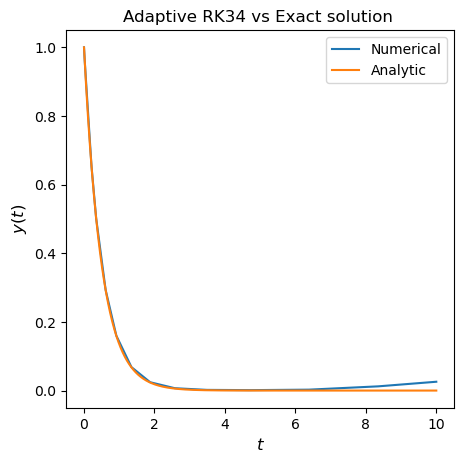

In [14]:
[t,y]=adaptiveRK34(f, 0, 10, 1, 10**(-1))
plt.plot(t,y)
plt.plot
x=np.linspace(0,10,10000)
plt.plot(x,testfunction(x))
plt.xlabel("$t$", fontsize=12)
plt.ylabel("$y(t)$", fontsize=12)
plt.title("Adaptive RK34 vs Exact solution ")
plt.legend(["Numerical", "Analytic"], loc ="upper right");

Here we choose a rather high tolerance of $0.1$ for illustration purposes.

## 3. A nonstiff problem

**Theory.** A classical model in biological population dynamics is the LotkaVolterra equation,

$$
\begin{aligned}
&\dot{x}=a x-b x y \\
&\dot{y}=c x y-d y,
\end{aligned}
$$

where $a, b, c, d$ are positive parameters. The equation models the interaction between a predator species, $y$ (foxes), and a prey, $x$ (rabbits). If no foxes are present $(y=0)$ the rabbits multiply and grow exponentially. On the other hand, if there are no rabbits $(x=0)$, the foxes have no food supply and die at a rate determined by $d$. The product term, $x y$, represents the probability that a fox encounters a rabbit within their shared ecosystem. This encounter benefits the fox, which eats the rabbit, so the product term is positive in the second (fox) equation, and negative in the first (rabbit) equation.

The Lotka-Volterra equation is separable. By dividing the two equations, we get

$$
\frac{\mathrm{d} x}{\mathrm{~d} y}=\frac{a x-b x y}{c x y-d y}=\frac{x(a-b y)}{y(c x-d)} .
$$

Written in terms of differentials, we have

$$
\left(c-\frac{d}{x}\right) \mathrm{d} x=\left(\frac{a}{y}-b\right) \mathrm{d} y,
$$

and by integration we obtain $c x-d \log x=a \log y-b y+K$. Hence the function

$$
H(x, y)=c x+b y-d \log x-a \log y
$$

remains constant at all times, i.e., $H(x, y)$ is invariant along solutions. This means (non-trivially, proof omitted) that the Lotka-Volterra equation has periodic solutions.

### Task 3.1

Choose the parameters $a, b, c, d$ as (3, 9, 15, 15) and pick some suitable positive initial values, preferably not too far from the equilibrium point $(d / c, a / b)$, e.g. $(1,1)$. Use your own adaptive RK34 solver to solve the problem. Run with a tolerance of (say) $10^{-6}$ or $10^{-8}$. (You can use tighter tolerances still, if your code is good enough.) Simulate the system for at least 10 full periods.

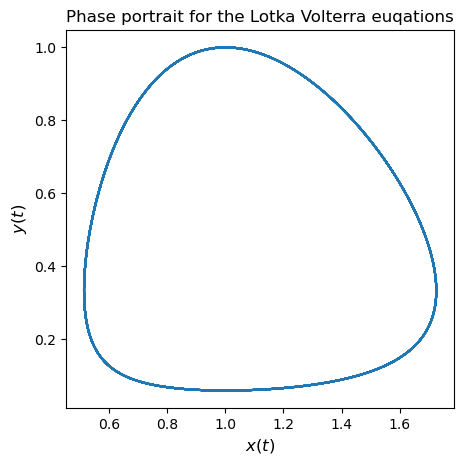

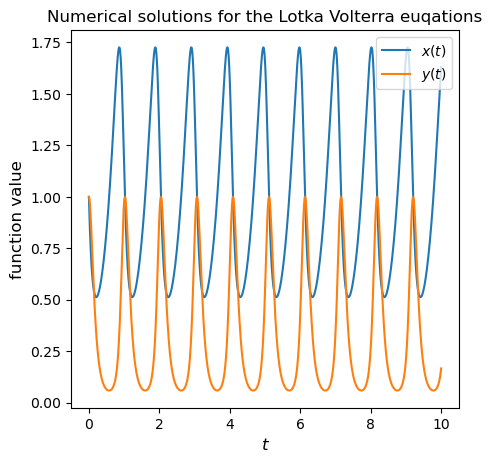

In [15]:
# The Lotka-Volterra system of diff.equation.
def lotka(t, u):
    [a, b, c, d] = [3, 9, 15, 15]
    return np.array([a*u[0] - b*u[0]*u[1], c*u[0]*u[1]-d*u[1]])

[t,y]=adaptiveRK34(lotka, 0, 10, [1,1], 10**(-8))
plt.plot(y[0], y[1])
plt.xlabel("$x(t)$", fontsize=12)
plt.ylabel("$y(t)$", fontsize=12)
plt.title("Phase portrait for the Lotka Volterra euqations");
plt.show()

plt.plot(t, y[0])
plt.plot(t, y[1])
plt.xlabel("$t$", fontsize=12)
plt.ylabel("function value", fontsize=12)
plt.title("Numerical solutions for the Lotka Volterra euqations")
plt.legend(["$x(t)$", "$y(t)$"], loc ="upper right");
plt.show()

Integrate over a very long time $(100-1,000$ full periods, depending on choice of tolerance) to check whether the numerically computed $H(x, y)$ stays near its initial value $H(x(0), y(0))$ or drifts away. This can be done by plotting

$$
|H(x, y) / H(x(0), y(0))-1|
$$

as a function of time, where you insert the computed values of $x$ and $y$ into the expression. Choose a suitable type of plot.

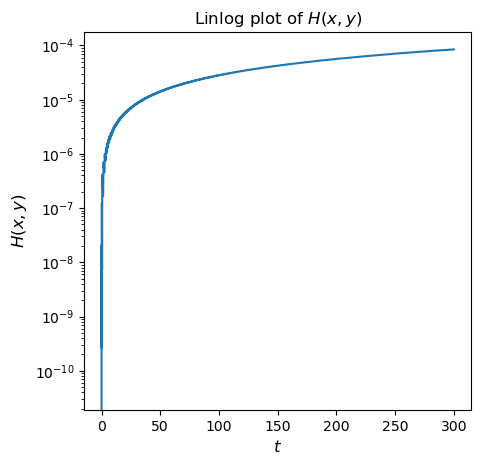

In [19]:
def H(x,y):
    [a, b, c, d] = [3, 9, 15, 15]
    return c*x + b*y - d*np.log(x) - a*np.log(y)

initial = [1,1]
[t,y]=adaptiveRK34(lotka, 0, 300, initial, 10**(-6))
values = np.absolute((H(y[0], y[1])/H(initial[0], initial[1]))-1)

plt.semilogy(t, values)
plt.xlabel("$t$", fontsize=12)
plt.ylabel("$H(x,y)$", fontsize=12)
plt.title("Linlog plot of $H(x,y)$");

## 3. Nonstiff and stiff problems

**Theory.** In an implicit method, every step is (far) more expensive due to the necessary (nonlinear) equation solving. This extra expense can pay off, however, if one can take much longer steps with the implicit method. This happens in stiff problems. Because all explicit methods have bounded stability regions, the maximum stable step size is limited (see lecture notes). A well designed implicit method, however, can have an unbounded stability region, permitting much larger steps without losing accuracy. This makes up for the extra work incurred by equation solving. The explicit and implicit Euler methods are the prototypical examples of this.

The van der Pol equation,

$$
\begin{aligned}
&y_{1}^{\prime}=y_{2} \\
&y_{2}^{\prime}=\mu \cdot\left(1-y_{1}^{2}\right) \cdot y_{2}-y_{1},
\end{aligned}
$$

models an electric oscillator circuit. The solution is periodic, with a period of approximately $2 \mu$. The system may be stiff or nonstiff depending on the parameter $\mu$. Use the initial condition $y(0)=\left[\begin{array}{ll}2 & 0\end{array}\right]^{\mathrm{T}}$.

### Task 3.1 
Solve the van der Pol equation for $\mu=100$ on the interval $[0,2 \mu]$ using your own explicit, adaptive RK34 code. Plot the solution component $y_{2}$ as function of time. Further, plot $y_{2}$ as a function of $y_{1}$ (the phase portrait). In the latter plot, try modifying the initial values, and check that the solution always tends to the same oscillation. Unlike the Lotka-Volterra equation, where you get different orbits, the van der Pol equation only has a single closed orbit, known as a limit cycle.

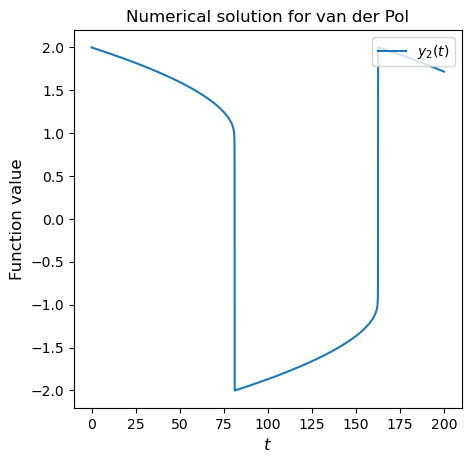

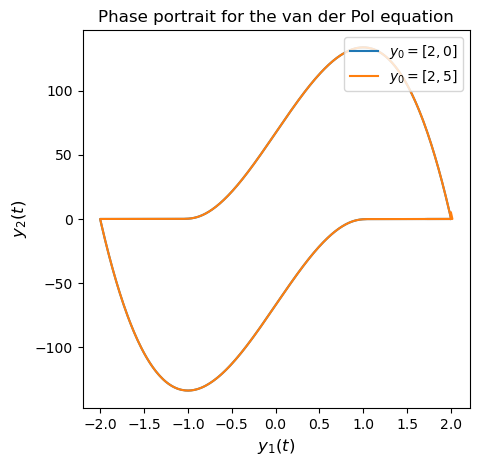

In [20]:
def vdpmu(mu):
    def vdp(t, u):
        return np.array([u[1], mu*(1-(u[0])**2)*u[1]-u[0]])
    return vdp

initial = [2,0]
[t,y]=adaptiveRK34(vdpmu(100), 0, 2*100, initial, 10**(-6))

plt.plot(t, y[0])
plt.xlabel("$t$", fontsize=12)
plt.ylabel("Function value", fontsize=12)
plt.title("Numerical solution for van der Pol")
plt.legend(["$y_2(t)$"], loc ="upper right");
plt.show()

plt.plot(y[0], y[1])

initial = [2,5]
[t,y]=adaptiveRK34(vdpmu(100), 0, 2*100, initial, 10**(-6))

plt.plot(y[0], y[1])

plt.xlabel("$y_1(t)$", fontsize=12)
plt.ylabel("$y_2(t)$", fontsize=12)
plt.title("Phase portrait for the van der Pol equation");
plt.legend(["$y_0=[2,0]$", "$y_0=[2,5]$"], loc ="upper right");
plt.show()

### Task 3.2
We are now going to explore stiffness, and how it depends on $\mu$. In all computations, use the initial condition $y(0)=\left[\begin{array}{ll}2 & 0\end{array}\right]^{\mathrm{T}}$, and for every given $\mu$, solve the problem on the time interval $[0,0.7 \mu]$, still using your own adaptive solver. Solve the problem for the "E6 series" of values of $\mu$, i.e., solve the problem for $\mu=10,15,22,33,47,68,100,150,220,330,470$.

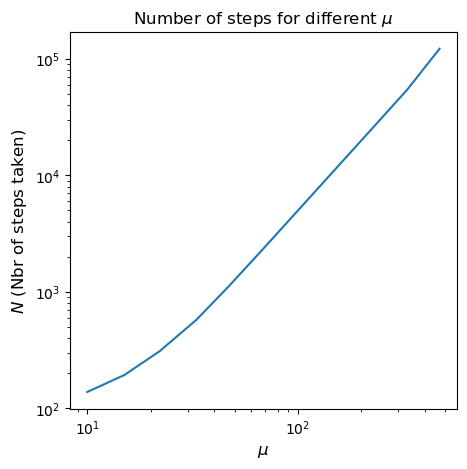

In [21]:
mu = [10, 15, 22, 33, 47, 68, 100, 150,220, 330, 470]

initial = [2,0]
N = np.array([])
for x in mu:
    [t,y]=adaptiveRK34(vdpmu(x), 0, 0.7*x, initial, 10**(-6))
    N = np.append(N, [y[0].size])

plt.loglog(mu, N)
plt.xlabel("$\mu$", fontsize=12)
plt.ylabel("$N$ (Nbr of steps taken)", fontsize=12)
plt.title("Number of steps for different $\mu$");

We can conclude that $N \sim C \cdot \mu^{q}$ where we see from the graph that $q \approx 2$, should probably do linear regression to be sure.

In [22]:
# regression to confirm q~2
regressor = LinearRegression()
N = np.log(N.reshape(-1,1))
mu = np.log(np.array(mu).reshape(-1,1))
regressor.fit(mu, N)
print(regressor.coef_)

[[1.8204155]]


### Task 3.3

Use the function `scipy.integrate.solve_IVP` and specify the parameter `method='BDF'`. Repeat the experiments from Tasks $3.2$ using one of these solvers, using the same data as before. 

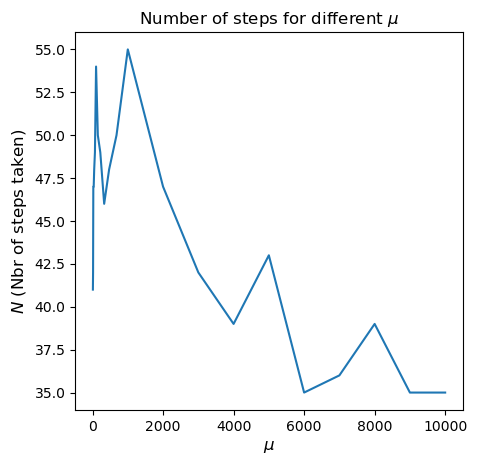

In [23]:
mu = [10, 15, 22, 33, 47, 68, 100, 150,220, 330, 470, 680, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
initial = [2,0]
N = np.array([])
#from sp.integrate import solve_IVP
for x in mu:
    y = sp.integrate.solve_ivp(vdpmu(x),(0, 0.7*x), initial, method='BDF')
    N = np.append(N, [y['t'].size])

plt.plot(mu, N)
plt.xlabel("$\mu$", fontsize=12)
plt.ylabel("$N$ (Nbr of steps taken)", fontsize=12)
plt.title("Number of steps for different $\mu$");